In [1]:
import itertools
import os
import pickle

import ffsim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lucj_ffsim.lucj import LUCJTask

MOL_DATA_DIR = "data/molecular_data"
DATA_DIR = "data/lucj"
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)


basis = "sto-6g"
ne, norb = 4, 4
molecule_basename = f"ethene_dissociation_{basis}_{ne}e{norb}o"

reference_curves_bond_distance_range = np.linspace(1.3, 4.0, 50)
# bond_distance_range = np.linspace(1.3, 4.0, 6)
bond_distance_range = np.linspace(1.3, 4.0, 20)
# bond_distance_range = np.linspace(1.3, 4.0, 50)
connectivities = [
    "all-to-all",
    "square",
    "hex",
    "heavy-hex",
]
n_reps_range = [
    2,
    4,
    6,
]
with_final_orbital_rotation_choices = [False]
# param_initialization_methods = ["ccsd"]
optimization_methods = [
    "L-BFGS-B",
    "linear-method",
]
maxiter = 10000

ansatz_settings = list(
    itertools.product(
        connectivities,
        n_reps_range,
        with_final_orbital_rotation_choices,
        # param_initialization_methods,
        optimization_methods,
    )
)
n_pts = len(bond_distance_range)

mol_datas_reference: dict[float, ffsim.MolecularData] = {}
mol_datas_experiment: dict[float, ffsim.MolecularData] = {}

for bond_distance in reference_curves_bond_distance_range:
    filename = os.path.join(
        MOL_DATA_DIR, f"{molecule_basename}_bond_distance_{bond_distance:.5f}.pickle"
    )
    with open(filename, "rb") as f:
        mol_data = pickle.load(f)
        mol_datas_reference[bond_distance] = mol_data

for bond_distance in bond_distance_range:
    filename = os.path.join(
        MOL_DATA_DIR, f"{molecule_basename}_bond_distance_{bond_distance:.5f}.pickle"
    )
    with open(filename, "rb") as f:
        mol_data = pickle.load(f)
        mol_datas_experiment[bond_distance] = mol_data

hf_energies_reference = np.array(
    [mol_data.hf_energy for mol_data in mol_datas_reference.values()]
)
fci_energies_reference = np.array(
    [mol_data.fci_energy for mol_data in mol_datas_reference.values()]
)
hf_energies_experiment = np.array(
    [mol_data.hf_energy for mol_data in mol_datas_experiment.values()]
)
fci_energies_experiment = np.array(
    [mol_data.fci_energy for mol_data in mol_datas_experiment.values()]
)

data = {}
infos = {}
for (
    connectivity,
    n_reps,
    with_final_orbital_rotation,
    # param_initialization,
    optimization_method,
) in ansatz_settings:
    for bond_distance in bond_distance_range:
        task = LUCJTask(
            molecule_basename=f"{molecule_basename}_bond_distance_{bond_distance:.5f}",
            connectivity=connectivity,
            n_reps=n_reps,
            with_final_orbital_rotation=with_final_orbital_rotation,
            # param_initialization=param_initialization,
            optimization_method=optimization_method,
            maxiter=maxiter,
            bootstrap_task=None,
        )
        filename = os.path.join(DATA_DIR, task.dirname, "data.pickle")
        with open(filename, "rb") as f:
            data[
                (
                    bond_distance,
                    connectivity,
                    n_reps,
                    with_final_orbital_rotation,
                    # param_initialization,
                    optimization_method,
                )
            ] = pickle.load(f)
        filename = os.path.join(DATA_DIR, task.dirname, "info.pickle")
        with open(filename, "rb") as f:
            infos[
                (
                    bond_distance,
                    connectivity,
                    n_reps,
                    with_final_orbital_rotation,
                    # param_initialization,
                    optimization_method,
                )
            ] = pickle.load(f)


keys = ["energy", "error", "spin_squared", "nit", "nfev", "nlinop"]
data = pd.DataFrame(
    list(
        zip(
            data.keys(),
            *zip(*[[d[k] for k in keys] for d in data.values()]),
        )
    ),
    columns=["key"] + keys,
)
data.set_index(
    pd.MultiIndex.from_tuples(
        data["key"],
        names=[
            "bond_distance",
            "connectivity",
            "n_reps",
            "with_final_orbital_rotation",
            # "param_initialization",
            "optimization_method",
        ],
    ),
    inplace=True,
)
data.drop(columns="key", inplace=True)  # Drop the original 'Key' column

Text(0.5, 0.98, 'Ethene dissociation STO-6g (4e, 4o) overlap matrix, heavy-hex, L=2')

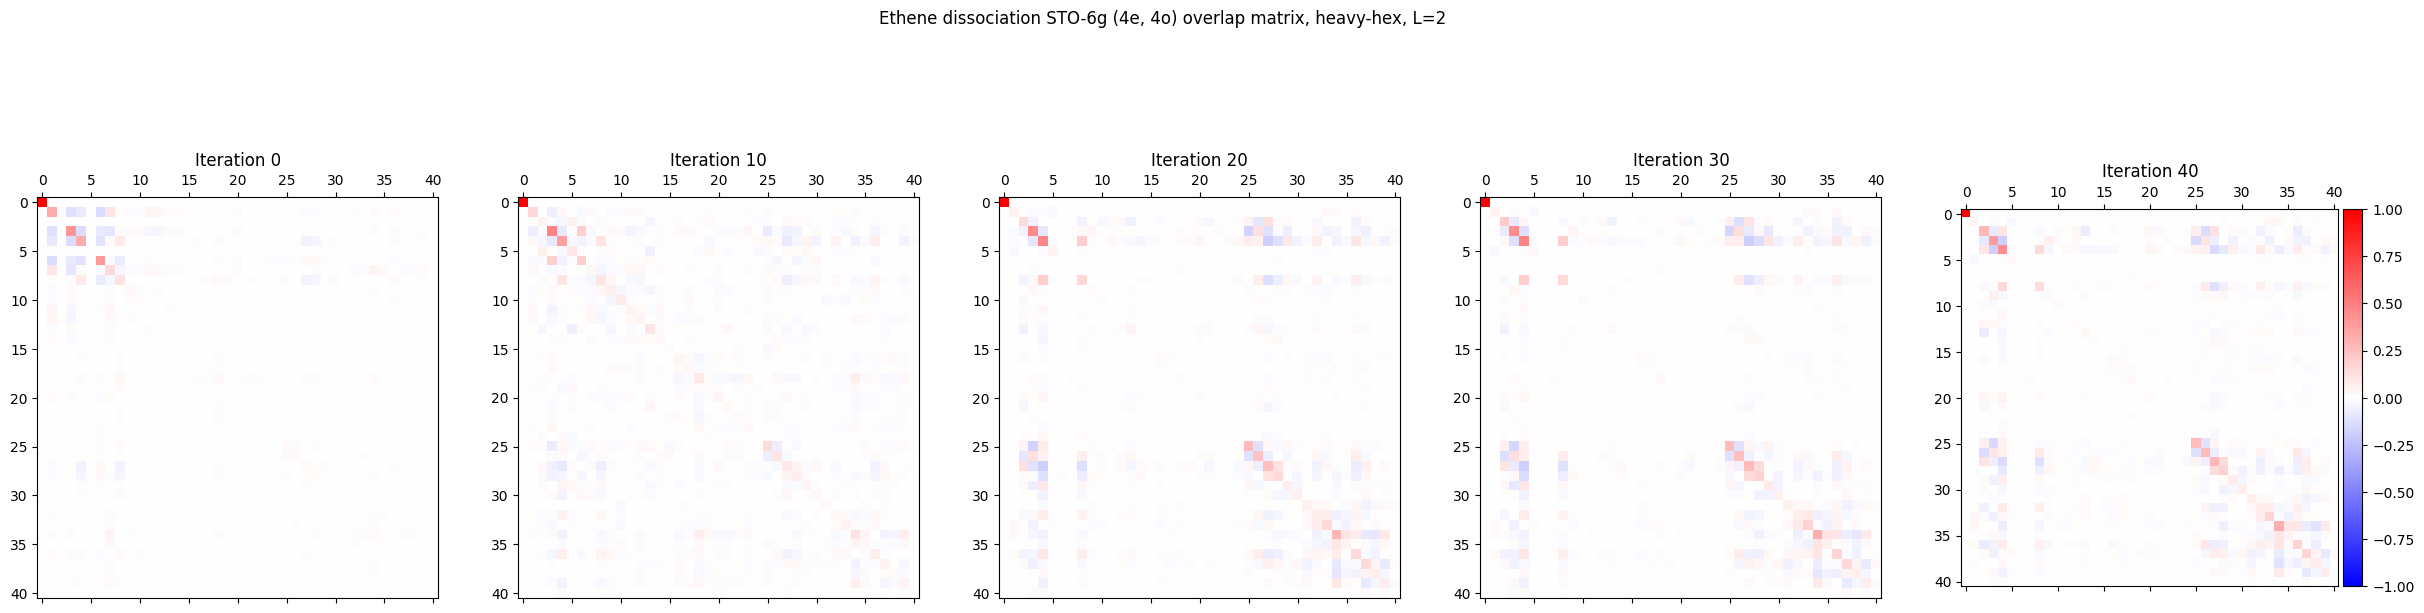

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

connectivity = "heavy-hex"
n_reps = 2
with_final_orbital_rotation = False
optimization_method = "linear-method"

these_infos = [
    infos[
        bond_distance,
        connectivity,
        n_reps,
        with_final_orbital_rotation,
        optimization_method,
    ]
    for bond_distance in bond_distance_range
]

info = these_infos[0]
overlap_mats = np.stack(info["overlap_mat"])
assert np.all(overlap_mats <= 1)
assert np.all(overlap_mats >= -1)

nit = len(overlap_mats)
n_mat = 5
step = nit // (n_mat - 1)
mats = overlap_mats[::step]
iteration_nums = range(0, nit, step)
assert len(mats) == n_mat

fig, axes = plt.subplots(1, n_mat, figsize=(6 * n_mat, 8))

for ax, mat, i in zip(axes, mats, iteration_nums):
    im = ax.matshow(mat, cmap="bwr", vmin=-1, vmax=1)
    ax.set_title(f"Iteration {i}")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

fig.suptitle(
    r"Ethene dissociation STO-6g (4e, 4o) overlap matrix"
    + f", {connectivity}, L={n_reps}"
)

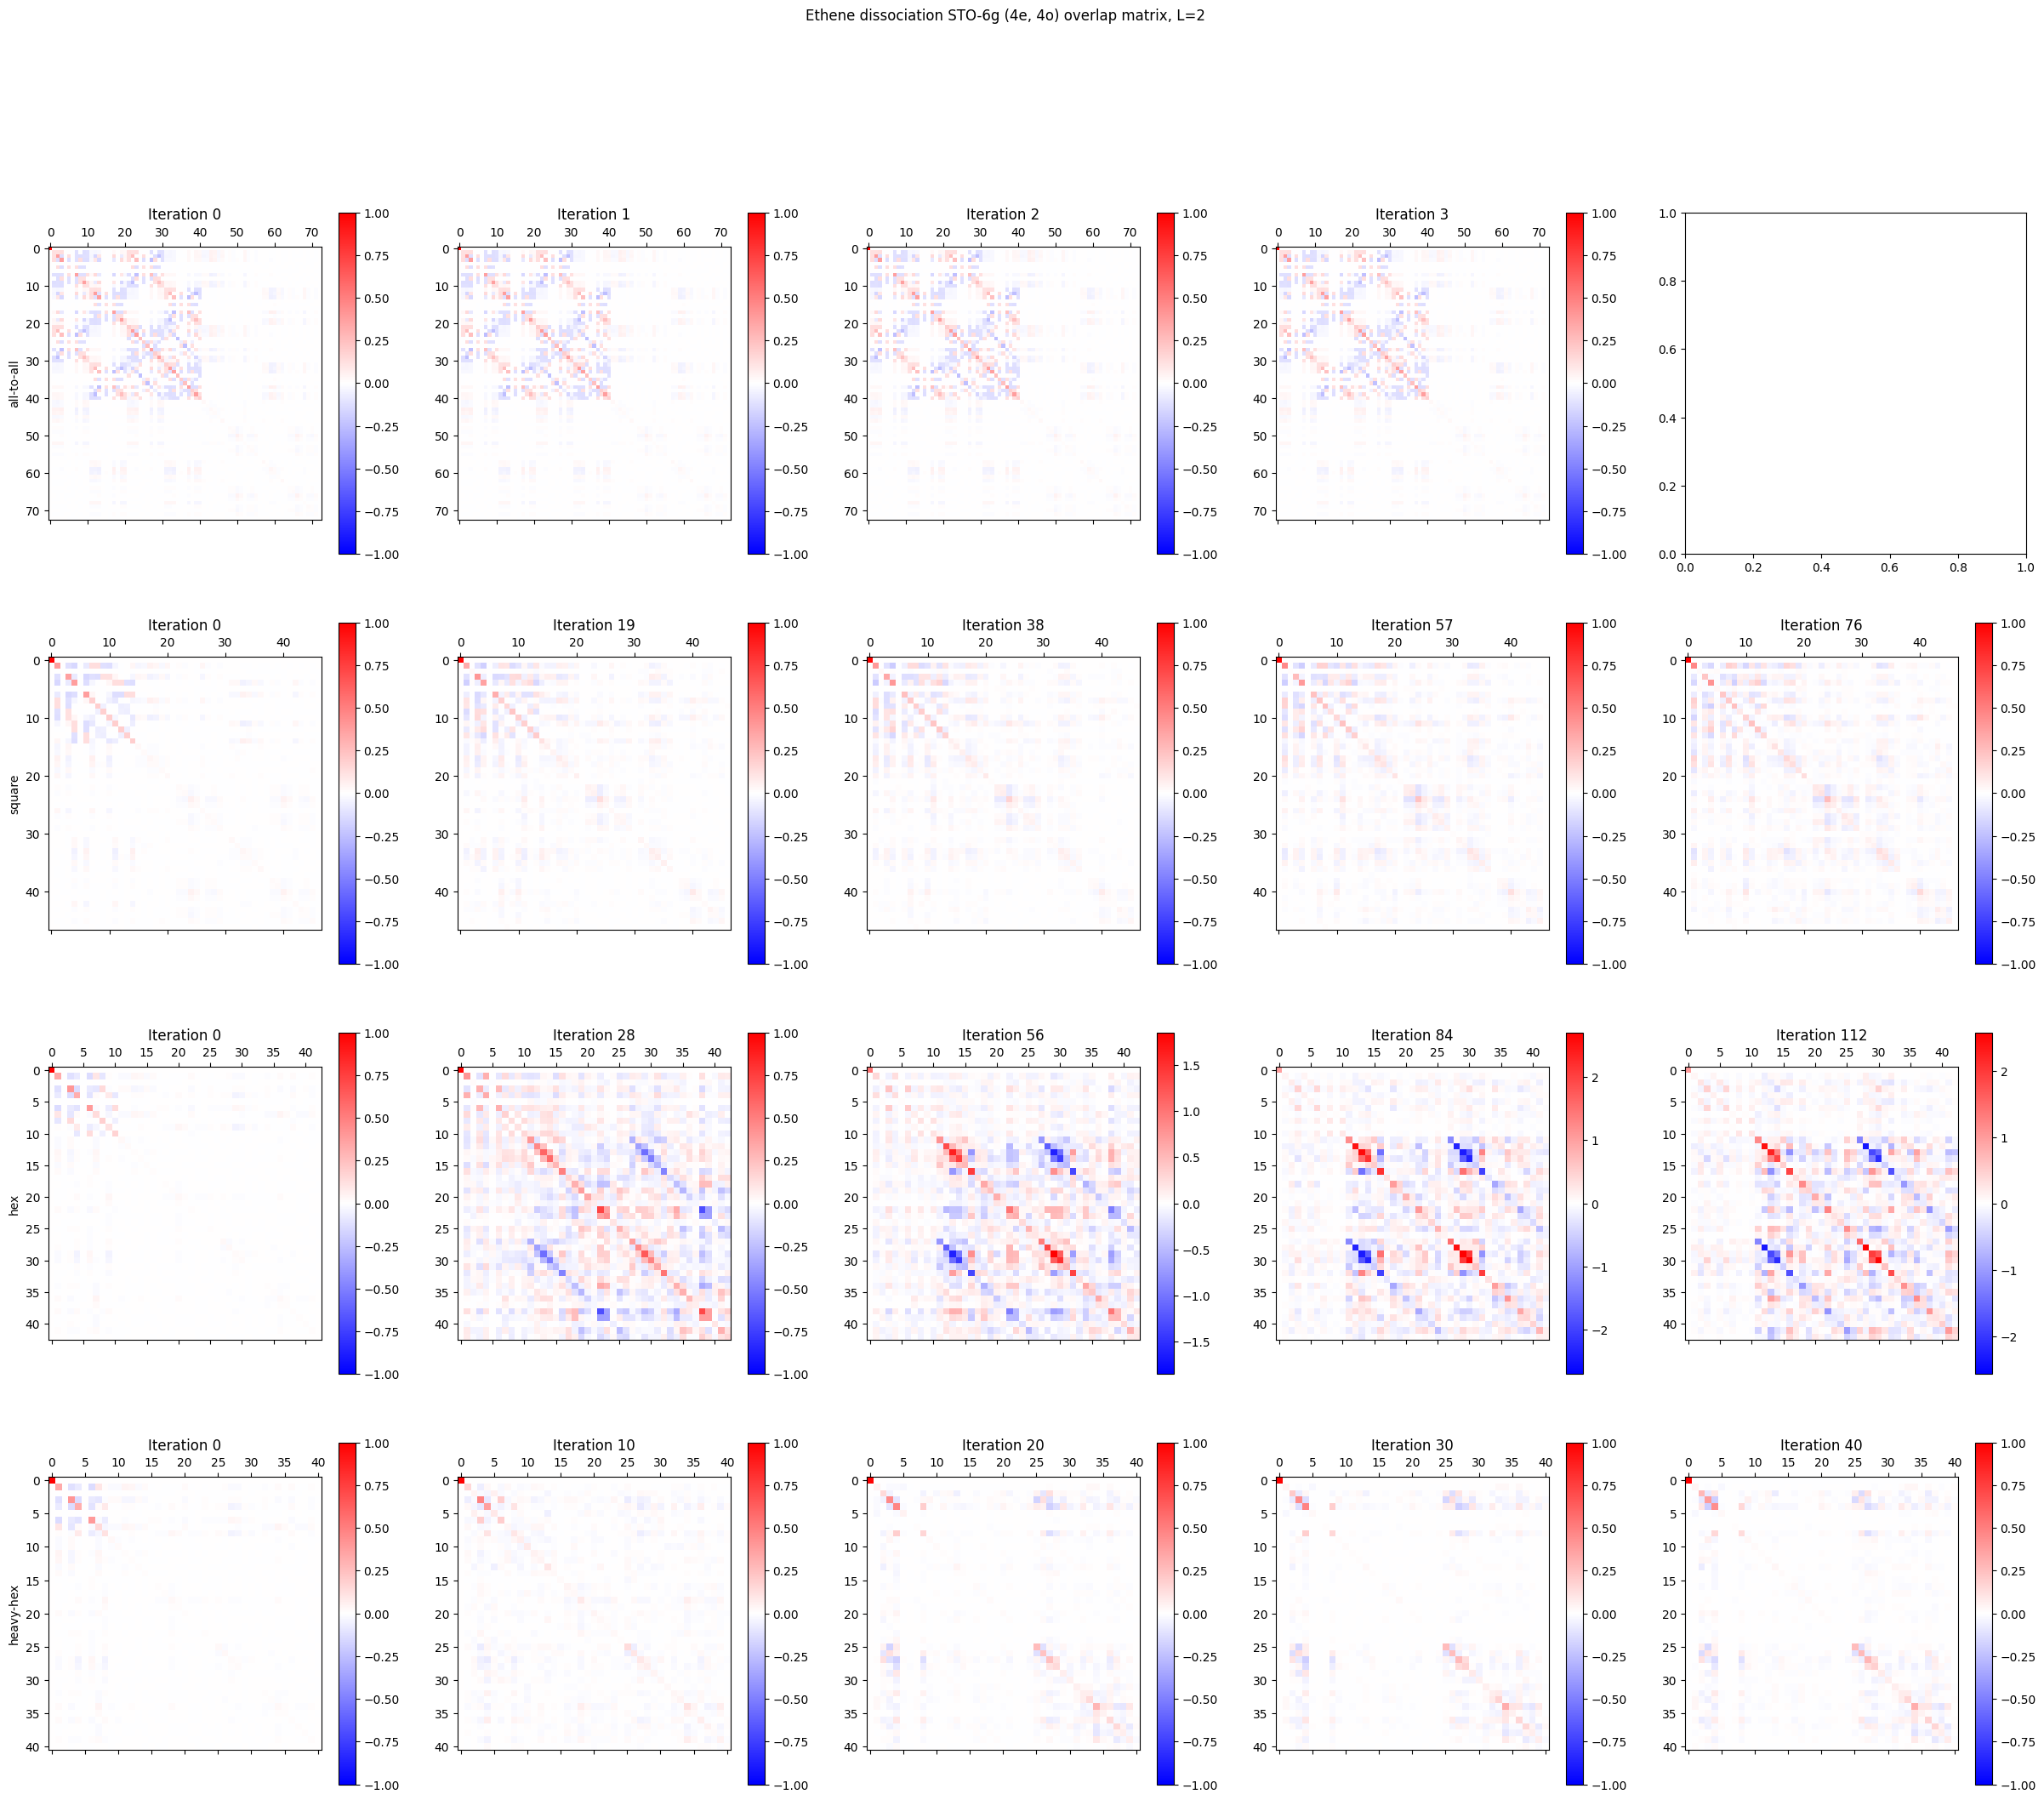

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_mat = 5
n_reps = 2

fig, axes = plt.subplots(
    len(connectivities), n_mat, figsize=(6 * n_mat, 6 * len(connectivities))
)

for these_axes, connectivity in zip(axes, connectivities):
    these_infos = [
        infos[
            bond_distance,
            connectivity,
            n_reps,
            False,
            "linear-method",
        ]
        for bond_distance in bond_distance_range
    ]

    info = these_infos[0]
    overlap_mats = np.stack(info["overlap_mat"])
    nit = len(overlap_mats)
    step = nit // (n_mat - 1)
    mats = list(overlap_mats[::step])
    iteration_nums = list(range(0, nit, step))
    assert len(mats) in (n_mat, n_mat - 1)
    # if len(mats) == n_mat - 1:
    #     mats.append(overlap_mats[-1])
    #     iteration_nums.append(nit - 1)

    for ax, mat, i in zip(these_axes, mats, iteration_nums):
        # assert np.all(mat <= 1.1)
        # assert np.all(mat >= -1.1)
        max_val = np.max(np.abs(mat))
        im = ax.matshow(
            mat,
            cmap="bwr",
            vmin=-max_val,
            vmax=max_val,
        )
        ax.set_title(f"Iteration {i}")
        if i == 0:
            ax.set_ylabel(connectivity)
        fig.colorbar(im)
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.suptitle(
        r"Ethene dissociation STO-6g (4e, 4o) overlap matrix" + f", L={n_reps}"
    )

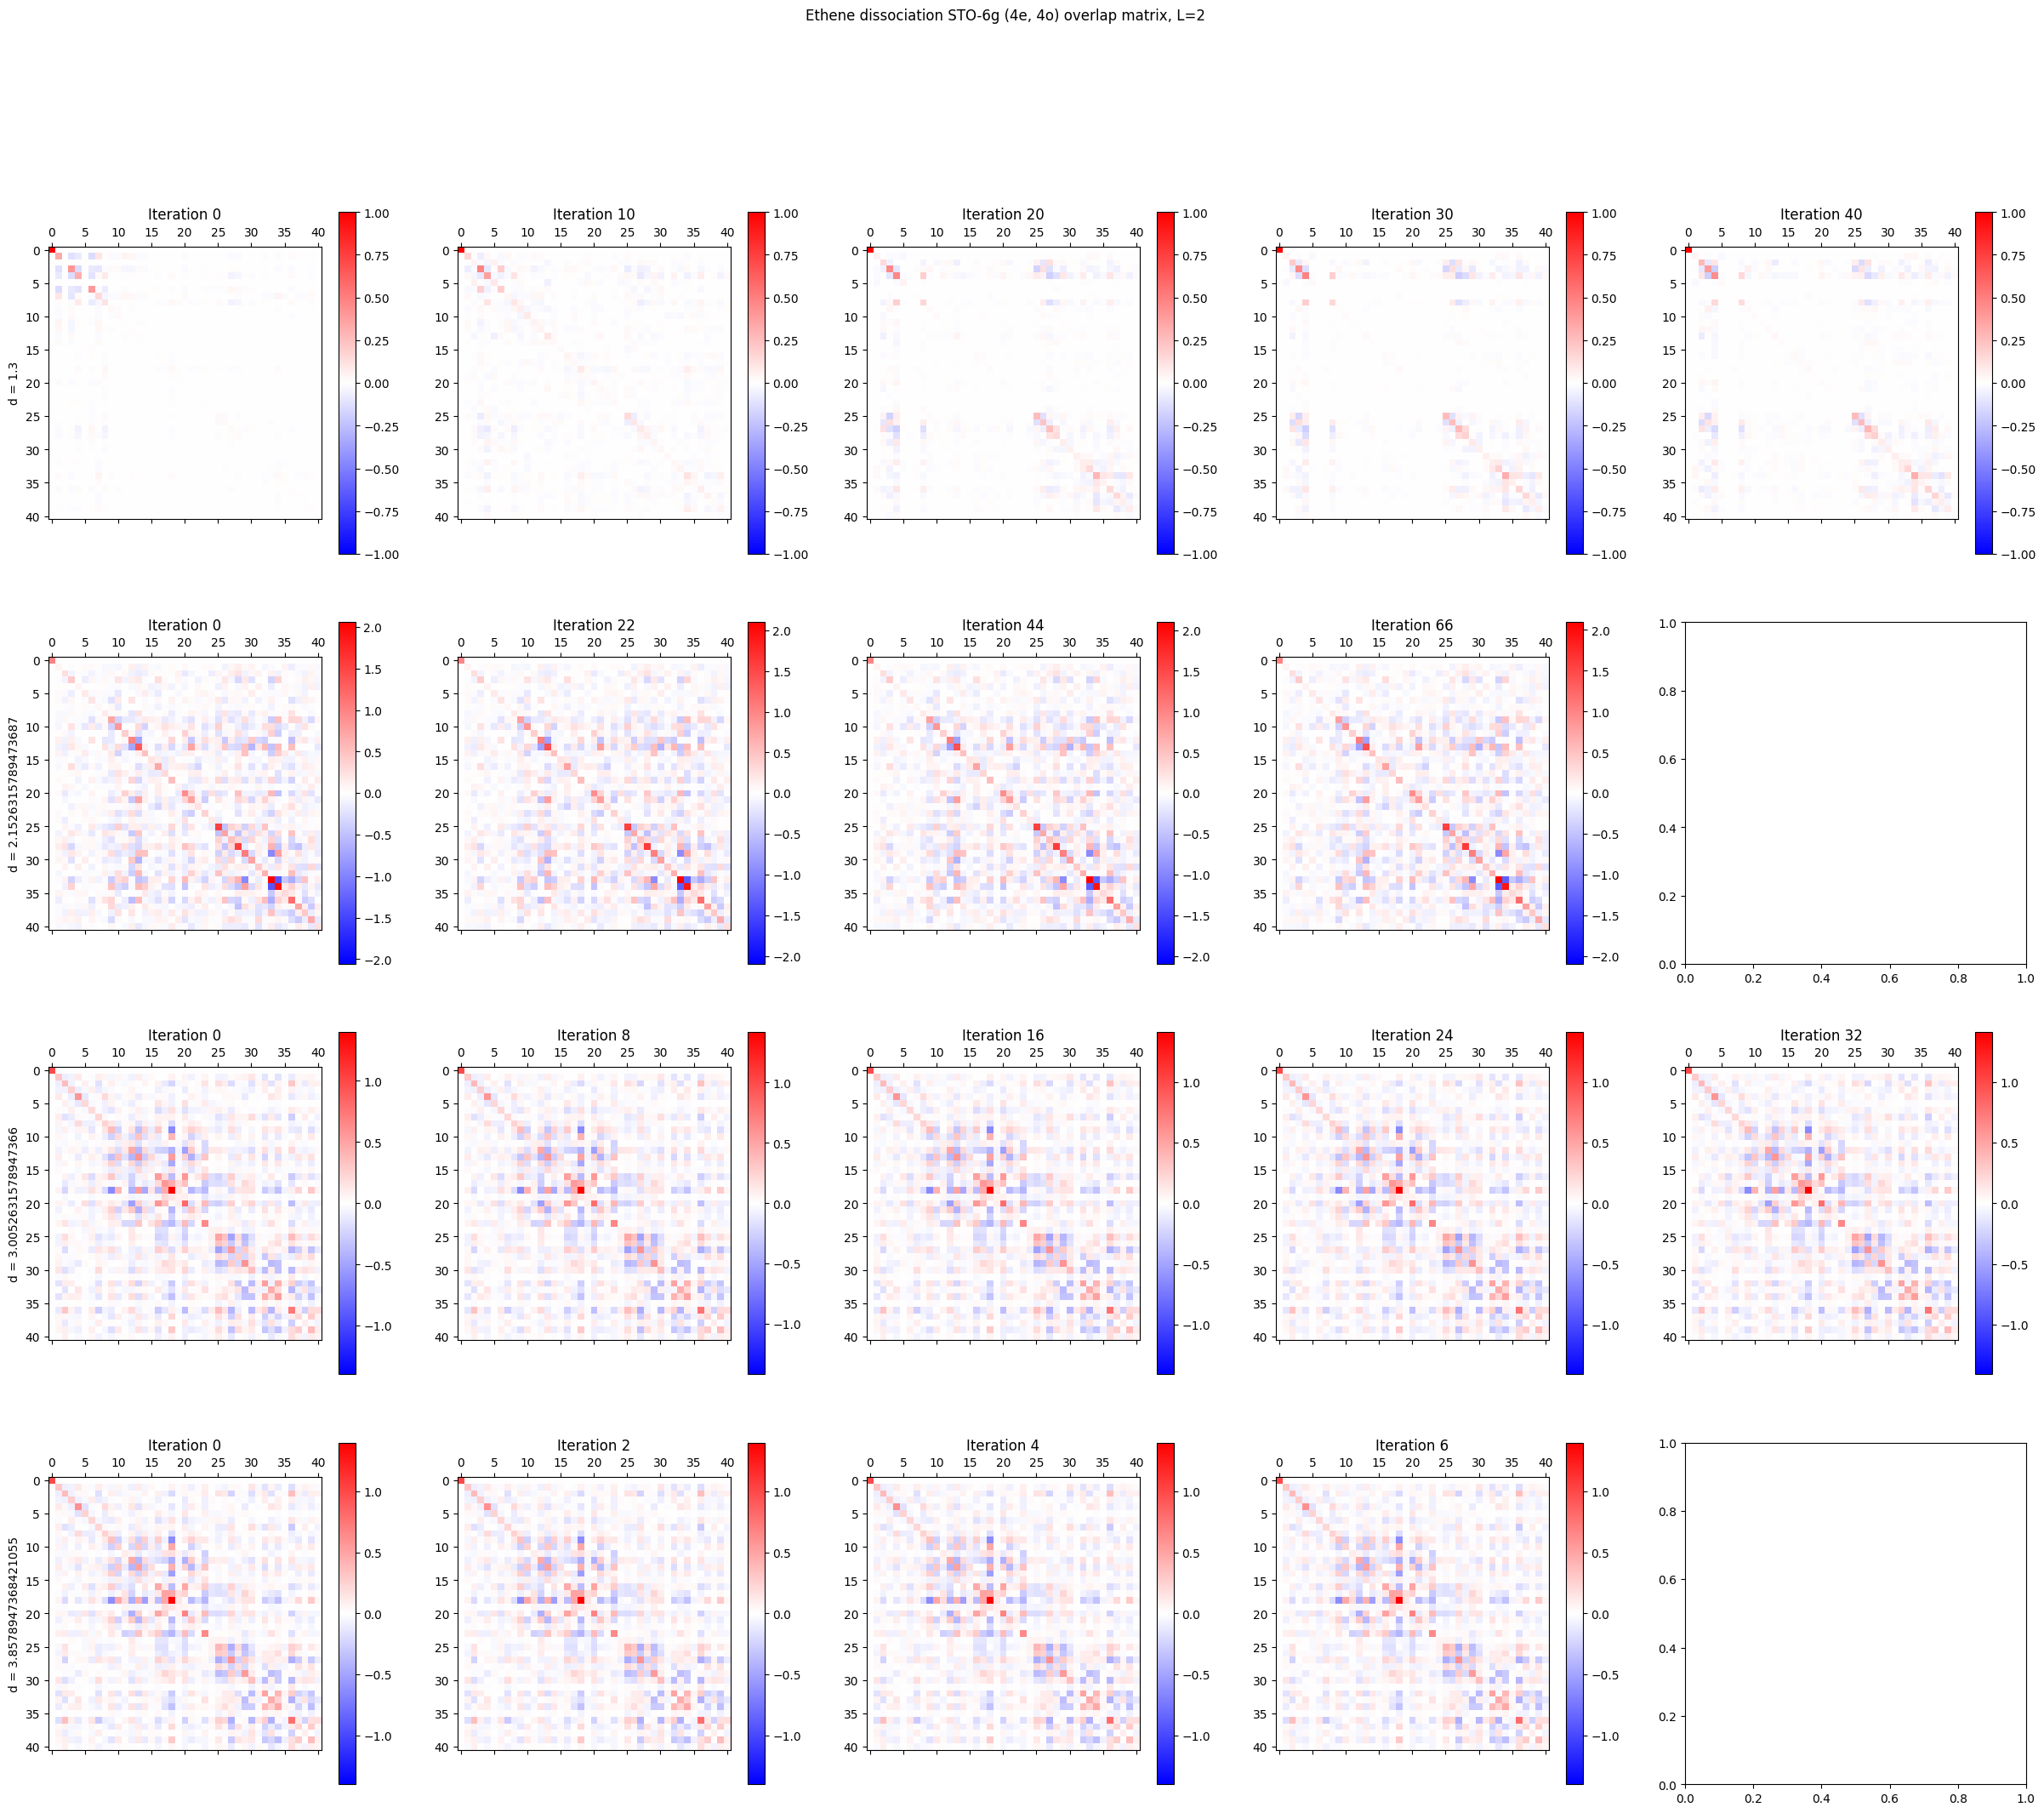

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

n_mat = 5
n_reps = 2
bond_distances = bond_distance_range[::6]
connectivity = "heavy-hex"

fig, axes = plt.subplots(
    len(bond_distances), n_mat, figsize=(6 * n_mat, 6 * len(bond_distances))
)

for these_axes, bond_distance in zip(axes, bond_distances):
    info = infos[
        bond_distance,
        connectivity,
        n_reps,
        False,
        "linear-method",
    ]

    overlap_mats = np.stack(info["overlap_mat"])
    nit = len(overlap_mats)
    step = nit // (n_mat - 1)
    mats = list(overlap_mats[::step])
    iteration_nums = list(range(0, nit, step))
    assert len(mats) in (n_mat, n_mat - 1)
    # if len(mats) == n_mat - 1:
    #     mats.append(overlap_mats[-1])
    #     iteration_nums.append(nit - 1)

    for ax, mat, i in zip(these_axes, mats, iteration_nums):
        # assert np.all(mat <= 1.1)
        # assert np.all(mat >= -1.1)
        max_val = np.max(np.abs(mat))
        im = ax.matshow(
            mat,
            cmap="bwr",
            vmin=-max_val,
            vmax=max_val,
        )
        ax.set_title(f"Iteration {i}")
        if i == 0:
            ax.set_ylabel(f"d = {bond_distance}")
        fig.colorbar(im)
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.suptitle(
        r"Ethene dissociation STO-6g (4e, 4o) overlap matrix" + f", L={n_reps}"
    )

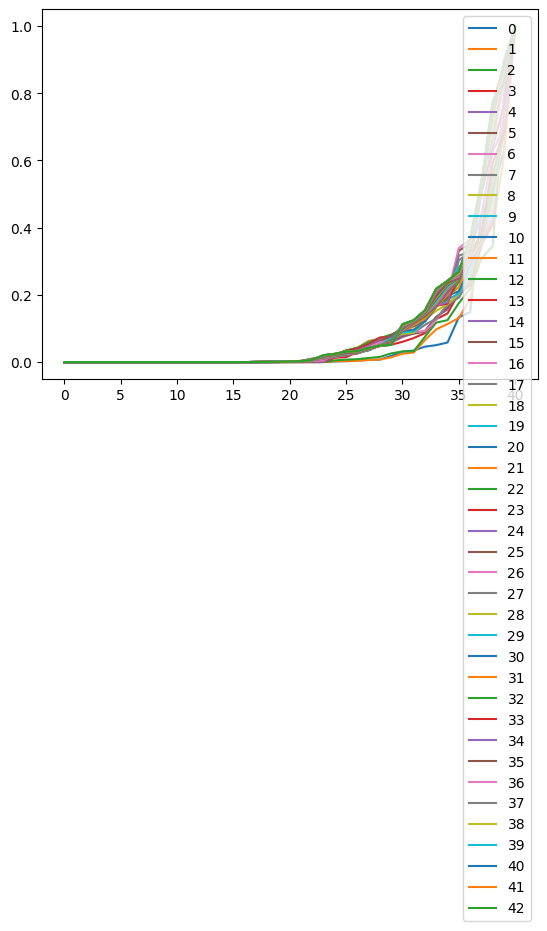

In [38]:
fig, ax = plt.subplots()
for i, mat in enumerate(overlap_mats):
    eigs, vecs = np.linalg.eigh(mat)
    ax.plot(eigs, label=f"{i}")
ax.legend()